In [19]:
import pandas as pd
from HSSL import *
# %% #### Imports ####
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from benchmark.results import load_all_results

## HNSW hyperparameter analysis

In [20]:
def find_cut(dendrogram):
	# https://github.com/sharpenb/Hierarchical-Paris-Clustering/
	from python_paris.homogeneous_cut_slicer import best_homogeneous_cut
	cut_level, cut_score = best_homogeneous_cut(np.array(dendrogram))
	# print(cut_level, cut_score)
	return len(dendrogram) + 1 - cut_level

In [21]:
def find_cut_old(dendrogram):

    distances = [d[2] for d in dendrogram]
    distances.sort(reverse=True)
    
    index = 0
    max_jump = -1
    for i in range(len(distances) - 1):
        d = distances[i] - distances[i + 1]

        if d > max_jump:
            max_jump = d
            index = i
    
    return index + 2

In [22]:
def get_clustering_from_dendrogram(dendrogram, k, min_cluster_size=10):
    # roundup_fix_dendrogram(dendrogram)
    N = len(dendrogram) + 1
    clustering = -np.ones(N+len(dendrogram), dtype=int)
    merge_distance_order = np.argsort([v[2] for v in dendrogram], kind="stable")
    final_clusters = set([2*N-2])
    i = len(merge_distance_order)-1
    while len(final_clusters) < k:
        final_clusters.remove(N+i)
        l,r = dendrogram[merge_distance_order[i]][:2]
        l_size = 1 if l<N else dendrogram[l-N][3]
        r_size = 1 if r<N else dendrogram[r-N][3]
        if l_size >= min_cluster_size: final_clusters.add(l)
        if r_size >= min_cluster_size: final_clusters.add(r)
        i -= 1
    final_clusters = np.sort([*final_clusters])
    for i,c in enumerate(final_clusters): clustering[c] = i
    for merged_index_diff, (cluster_i, cluster_j, _, _) in enumerate(reversed(dendrogram)):
        merged_index = N + len(dendrogram) - merged_index_diff - 1
        if merged_index > final_clusters[-1]: continue
        clustering[[cluster_i, cluster_j]] = clustering[merged_index]
    return clustering[:N]
# clustering = get_clustering_from_dendrogram(dendrogram, 5, 5)
# print(np.unique(clustering, return_counts=True))
# clustering

In [23]:
def ARI_score(dendro1, dendro2): 
        
        dendro1 = [[int(l), int(r), float(d), int(s)] for l, r, d, s in dendro1]
        dendro2 = [[int(l), int(r), float(d), int(s)] for l, r, d, s in dendro2]

        dendro1 = elki_sort_dendrogram(dendro1)
        dendro2 = elki_sort_dendrogram(dendro2)
        
        k = find_cut(dendro1)

        C1 = get_clustering_from_dendrogram(dendro1, k)
        C2 = get_clustering_from_dendrogram(dendro2, k)

        return adjusted_rand_score(C1, C2)


In [24]:
# %%
datasets = ['blobs-32k-10-5']

data = []
exact_data = {}

# load all the results that are available for the dataset

for dataset in datasets:
    for f in load_all_results(dataset, ""):
        if f.attrs['algo'] == 'VPTreehssl':
            exact_data[dataset] = f["dendrogram"][:]
            break


for dataset in datasets:
    for f in load_all_results(dataset, ""):
        if f.attrs['algo'] == "HNSWhssl":
            ARI = ARI_score(exact_data[dataset], f["dendrogram"][:])
            data.append({
            "algo": f.attrs['algo'],
            "time": f.attrs['time'],
            "n": len(f["dendrogram"][:]) + 1,
            "params": f.attrs["params"],
            "ARI": ARI
            })

df = pd.DataFrame(data=data)
df

,algo,time,n,params,ARI
0,HNSWhssl,602.621035,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 10}",0.999922
1,HNSWhssl,437.020101,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 20}",1.000000
2,HNSWhssl,427.586940,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 40}",1.000000
3,HNSWhssl,376.445651,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 5}",1.000000
4,HNSWhssl,467.287630,32000,"{""ef"": 20, ""ef_construct"": 200, ""M"": 10}",0.999922
5,HNSWhssl,429.746890,32000,"{""ef"": 20, ""ef_construct"": 200, ""M"": 20}",1.000000
6,HNSWhssl,447.295637,32000,"{""ef"": 20, ""ef_construct"": 200, ""M"": 40}",1.000000
7,HNSWhssl,514.565284,32000,"{""ef"": 20, ""ef_construct"": 200, ""M"": 5}",0.999961
8,HNSWhssl,532.640236,32000,"{""ef"": 20, ""ef_construct"": 25, ""M"": 10}",0.999844
9,HNSWhssl,375.025369,32000,"{""ef"": 20, ""ef_construct"": 25, ""M"": 20}",1.000000


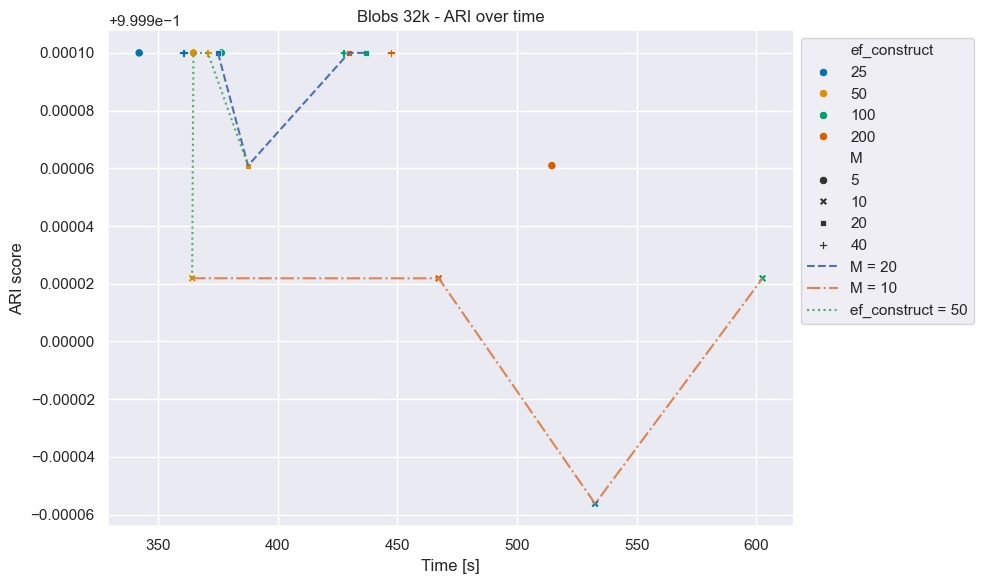

In [25]:
import seaborn as sns
import json

if 'M' and 'ef_construct' and 'ef' not in df.columns:
    df["params_dict"] = df["params"].apply(lambda x: json.loads(x))

    params_df = df["params_dict"].apply(pd.Series)
    df = pd.concat([df, params_df], axis=1)


sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="time", y="ARI", hue="ef_construct", style="M", palette="colorblind", sizes=(50, 200))

fixed_M = 20
fixed_M2 = 10
fixed_ef_construct = 50

lines1_df = df[df['M'] == fixed_M]
lines1_df2 = df[df['M'] == fixed_M2]
lines2_df = df[df['ef_construct'] == fixed_ef_construct]

sns.lineplot(data=lines1_df, x='time', y='ARI', linestyle='--', label=f'M = {fixed_M}')
sns.lineplot(data=lines1_df2, x='time', y='ARI', linestyle='-.', label=f'M = {fixed_M2}')
sns.lineplot(data=lines2_df, x='time', y='ARI', linestyle=':', label=f'ef_construct = {fixed_ef_construct}')

plt.title("Blobs 32k - ARI over time")
plt.xlabel("Time [s]")
plt.ylabel("ARI score")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
lines1_df = df[df['M'] == fixed_M]
lines1_df2 = df[df['M'] == fixed_M2]
lines2_df = df[df['ef_construct'] == fixed_ef_construct]

lines2_df.sort_values('time')

,algo,time,n,params,ARI,params_dict,ef,ef_construct,M
12,HNSWhssl,364.243223,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 10}",0.999922,"{'ef': 20, 'ef_construct': 50, 'M': 10}",20,50,10
15,HNSWhssl,364.779834,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 5}",1.000000,"{'ef': 20, 'ef_construct': 50, 'M': 5}",20,50,5
14,HNSWhssl,370.795748,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 40}",1.000000,"{'ef': 20, 'ef_construct': 50, 'M': 40}",20,50,40
13,HNSWhssl,387.602766,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 20}",0.999961,"{'ef': 20, 'ef_construct': 50, 'M': 20}",20,50,20


In [27]:
import json
param_filter = lambda df, *args: (
    param_filter(df[df.apply(lambda v: args[1](json.loads(v["params"])[args[0]]), axis=1)], *args[2:])
    if len(args) >= 2 else df
)
p = param_filter(df, "ef_construct", lambda x: x <= 100, "M", lambda x: x<20)
p

,algo,time,n,params,ARI,params_dict,ef,ef_construct,M
0,HNSWhssl,602.621035,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 10}",0.999922,"{'ef': 20, 'ef_construct': 100, 'M': 10}",20,100,10
3,HNSWhssl,376.445651,32000,"{""ef"": 20, ""ef_construct"": 100, ""M"": 5}",1.000000,"{'ef': 20, 'ef_construct': 100, 'M': 5}",20,100,5
8,HNSWhssl,532.640236,32000,"{""ef"": 20, ""ef_construct"": 25, ""M"": 10}",0.999844,"{'ef': 20, 'ef_construct': 25, 'M': 10}",20,25,10
11,HNSWhssl,342.100040,32000,"{""ef"": 20, ""ef_construct"": 25, ""M"": 5}",1.000000,"{'ef': 20, 'ef_construct': 25, 'M': 5}",20,25,5
12,HNSWhssl,364.243223,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 10}",0.999922,"{'ef': 20, 'ef_construct': 50, 'M': 10}",20,50,10
15,HNSWhssl,364.779834,32000,"{""ef"": 20, ""ef_construct"": 50, ""M"": 5}",1.000000,"{'ef': 20, 'ef_construct': 50, 'M': 5}",20,50,5


In [28]:
import json
print(df)
if 'M' and 'ef_construct' and 'ef' not in df.columns:
    df["params_dict"] = df["params"].apply(lambda x: json.loads(x))
    print(df["params_dict"])
    params_df = df["params_dict"].apply(pd.Series)
    print(params_df)
    df2 = pd.concat([df, params_df], axis=1)

    df2

        algo        time      n                                    params  \
0   HNSWhssl  602.621035  32000  {"ef": 20, "ef_construct": 100, "M": 10}   
1   HNSWhssl  437.020101  32000  {"ef": 20, "ef_construct": 100, "M": 20}   
2   HNSWhssl  427.586940  32000  {"ef": 20, "ef_construct": 100, "M": 40}   
3   HNSWhssl  376.445651  32000   {"ef": 20, "ef_construct": 100, "M": 5}   
4   HNSWhssl  467.287630  32000  {"ef": 20, "ef_construct": 200, "M": 10}   
5   HNSWhssl  429.746890  32000  {"ef": 20, "ef_construct": 200, "M": 20}   
6   HNSWhssl  447.295637  32000  {"ef": 20, "ef_construct": 200, "M": 40}   
7   HNSWhssl  514.565284  32000   {"ef": 20, "ef_construct": 200, "M": 5}   
8   HNSWhssl  532.640236  32000   {"ef": 20, "ef_construct": 25, "M": 10}   
9   HNSWhssl  375.025369  32000   {"ef": 20, "ef_construct": 25, "M": 20}   
10  HNSWhssl  360.645293  32000   {"ef": 20, "ef_construct": 25, "M": 40}   
11  HNSWhssl  342.100040  32000    {"ef": 20, "ef_construct": 25, "M": 5}   

In [29]:
from benchmark.results import load_all_results

datasets = ['blobs-2k-10-5',
            'blobs-4k-10-5',
            'blobs-8k-10-5',
            'blobs-16k-10-5',
            'blobs-32k-10-5',
            'blobs-64k-10-5',
            'blobs-128k-10-5'
            # 'mnist'
            ]

data = []

# load all the results that are available for the dataset
for S in datasets:
    for f in load_all_results(S, ""):
        if f.attrs['algo'] != "sklearn":
            data.append({
                "algo": f.attrs['algo'],
                "time": f.attrs['time'],
                "n": len(f["dendrogram"][:]) + 1
                })

df = pd.DataFrame(data=data)
df

,algo,time,n
0,HNSWhssl,9.907327,2000
1,HNSWhssl,9.806307,2000
2,HNSWhssl,9.371044,2000
3,HNSWhssl,9.302326,2000
4,HNSWhssl,9.838251,2000
...,...,...,...
58,scipy,9.938044,32000
59,VPTreehssl,3398.967253,32000
60,HNSWhssl,1480.768083,64000
61,scipy,62.422956,64000


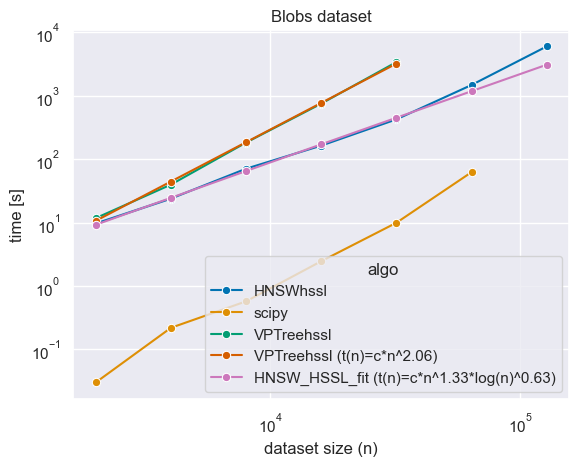

In [30]:
import seaborn as sns
from scipy.stats import linregress
from scipy.optimize import minimize

plot_df = df.copy()
fit_xs = df[df["algo"]=="VPTreehssl"]["n"].to_numpy()
fit_ys = df[df["algo"]=="VPTreehssl"]["time"].to_numpy()
sel = np.argsort(fit_xs)[:]
fit_model = linregress(np.log(fit_xs[sel]),np.log(fit_ys[sel]))
plot_df = pd.concat([plot_df, pd.DataFrame([
    [f"VPTreehssl (t(n)=c*n^{fit_model.slope:.2f})", x**fit_model.slope * np.exp(fit_model.intercept), x]
    for x in fit_xs
], columns=plot_df.columns)], axis=0)

def poly_log_fit(x, params):
    a, b, c = params
    return a*x**b*np.log(x)**c
def poly_log_fit_opt(x,y):
    def target(params):
        return np.sum(np.square(np.log(poly_log_fit(x,params))-np.log(y)))
    result = minimize(target, np.array([y[0]/x[0],1,0]), bounds=[
        (1e-20, 1e2*y[0]/x[0]),
        (1, 3),
        (0, 4)
    ])
    return result.x, result.fun
fit_xs = df[df["algo"]=="HNSWhssl"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HNSWhssl"]["time"].to_numpy()
sel = np.argsort(fit_xs)[:]
model_params, score = poly_log_fit_opt(fit_xs[sel], fit_ys[sel])
# print(model_params, score)
plot_df = pd.concat([plot_df, pd.DataFrame([
    [f"HNSW_HSSL_fit (t(n)=c*n^{model_params[1]:.2f}*log(n)^{model_params[2]:.2f})", poly_log_fit(x, model_params), x]
    for x in fit_xs
], columns=plot_df.columns)], axis=0)


ax = sns.lineplot(data=plot_df, x='n', y='time', hue="algo", marker='o', palette="colorblind")
ax.set_title('Blobs dataset')
ax.set_xlabel('dataset size (n)')
ax.set_ylabel('time [s]')
ax.set_xscale("log")
ax.set_yscale("log")

# Set gridlines and ticks
# x_log_min = np.log10(min(times['eps']))
# x_log_max = np.log10(max(times['eps']))
# xticks = np.logspace(x_log_min, x_log_max, num = 7)
# xticks = [round(x, 1) for x in xticks]
# y_log_min = np.log10(min(times['time']))
# y_log_max = np.log10(max(times['time']))
# yticks = np.logspace(y_log_min, y_log_max, num = 5)
# yticks = [int(x) for x in yticks]
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks)
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

['dendrogram']


Drawing lines:   0%|          | 0/129179 [00:00<?, ?it/s]

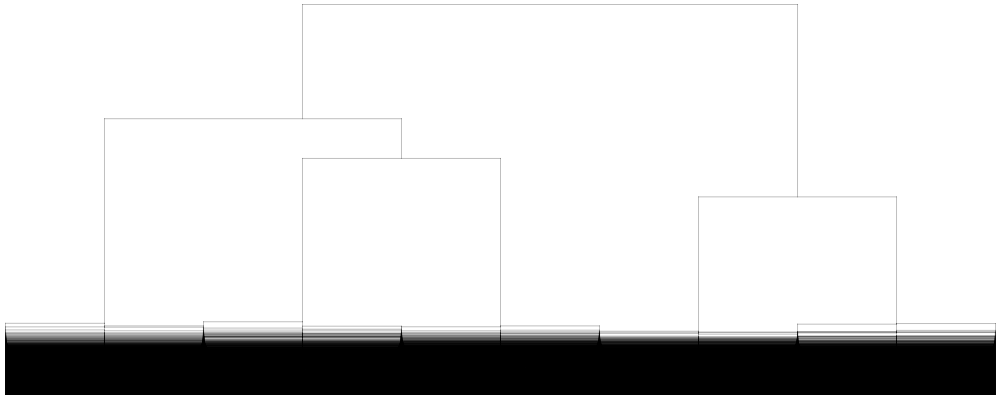

In [31]:
path = r'results\blobs-32k-10-5\VPTreehssl\run.hdf5'
# path = 'results/iris/HSSL_Turbo/dendro.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    den = f['dendrogram'][:]

den = [[int(a), int(b), c, int(d)] for a, b, c, d in den]
plotly_dendrogram(den, min_size=2, largest_left=False)

In [ ]:
path = r'results\blobs-32k-10-5\HNSWhssl\20_200_20.hdf5'
# path = 'results/iris/HSSL_Turbo/dendro.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    den = f['dendrogram'][:]

den = [[int(a), int(b), c, int(d)] for a, b, c, d in den]
plotly_dendrogram(den, min_size=2, largest_left=False)

['dendrogram']


Drawing lines:   0%|          | 0/129174 [00:00<?, ?it/s]

In [ ]:
find_cut(den)

5

In [ ]:
import random

# path = r'data\blobs-2k-10-5.hdf5'
path = r'data\\blobs-128k-10-5.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    # print(len(f['data'][:]))
    # print(f['dendrogram'][:])
    data = f['data'][:]

['data', 'dendrogram']


In [ ]:
import traceback
import os
from typing import Any, Optional, Set, Tuple, Iterator

def build_result_filepath(dataset_name: Optional[str] = None, 
                          eps: Optional[float] = None,
                          minPts: Optional[int] = None,
                          algorithm: Optional[any] = None,
                          arguments: Optional[Any] = None) -> str:
    d = ["results"]
    if dataset_name:
        d.append(dataset_name)
    if eps:
        d.append(str(eps))
    if minPts:
        d.append(str(minPts))
    if algorithm:
        d.append(algorithm)
        #data = definition.arguments + query_arguments
        #d.append(re.sub(r"\W+", "_", json.dumps(data, sort_keys=True)).strip("_") + ".hdf5")
        if arguments:
            d.append(arguments+".hdf5")
        else:
            d.append("run.hdf5")
    return os.path.join(*d)

def load_all_results(dataset: Optional[str] = None, prefix: str = ".") -> Iterator[Tuple[h5py.File]]:
    for root, _, files in os.walk(os.path.join(prefix, build_result_filepath(dataset))):
        for filename in files:
            if os.path.splitext(filename)[-1] != ".hdf5":
                continue
            try:
                with h5py.File(os.path.join(root, filename), "r+") as f:
                    yield f
            except Exception:
                print(f"Was unable to read {filename}")
                traceback.print_exc()

In [ ]:
# %% #### ARI score example run ####
p1 = r'results\blobs-2k-10-5\HNSWhssl\20_100_20.hdf5'
p2 = r'results\blobs-2k-10-5\VPTreehssl\run.hdf5'

# ARI_score(p1, p2)